In [ ]:
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import utils.dataset_processing_utils as dputil

SEED = 42
np.random.seed(SEED)

In [2]:
treatments_df = dputil.load_dataset("unodc_drug_treatment.xlsx")

NameError: name 'dputil' is not defined

---

### *unodc_treatments* dataset

#### feature overview

In [34]:
treatments_df.sample(10,random_state=SEED)

,Region,SubRegion,Country,msCode,Reference year,DrugGroup,Drug,Sex,Value,Campaign,Coverage
10172,Europe,Western and Central Europe,Portugal,PRT,2019,Non-medical use of pharmaceutical sedatives an...,Benzodiazepines,Total,30,HIST2019,National
10322,Europe,Western and Central Europe,Slovakia,SVK,2021,Solvents and inhalants,Solvents and inhalants,Total,20,ARQ2021,NaN
9195,Europe,Western and Central Europe,Luxembourg,LUX,2018,Non-medical use of pharmaceutical sedatives an...,Benzodiazepines,Total,1,HIST2019,National
357,Africa,Southern Africa,South Africa,ZAF,2020,Cocaine-type drugs,"“Crack” cocaine, freebase cocaine",Males,118,ARQ2020,NaN
4352,Asia,East and South-East Asia,Singapore,SGP,2021,"Opioids, including opiates and synthetic opioids",Other pharmaceutical opioids,Total,1,ARQ2021,NaN
6810,Europe,Western and Central Europe,Belgium,BEL,2020,Cannabis-type drugs,Cannabis herb (marijuana),Males,474,ARQ2020,NaN
11740,Europe,Western and Central Europe,United Kingdom,GBR,2020,"Opioids, including opiates and synthetic opioids",Methadone,Females,470,ARQ2021,NaN
11639,Europe,Western and Central Europe,United Kingdom,GBR,2019,"Opioids, including opiates and synthetic opioids","Opioids, including opiates and synthetic opioids",Males,35923,ARQ2020,NaN
9455,Europe,Western and Central Europe,Norway,NOR,2020,Other drugs / psychoactive substances / pharma...,Other drugs / psychoactive substances / pharma...,Males,2031,ARQ2020,NaN
9792,Europe,Western and Central Europe,Poland,POL,2018,Cocaine-type drugs,Cocaine-type drugs,Total,173,HIST2019,National


In [35]:
edited_treatments_df = treatments_df.rename(columns={
    "Region": "region",
    "SubRegion": "sub_region",
    "Country": "country",
    "Reference year": "year",
    "DrugGroup": "drug_group",
    "Drug": "drug_sub_group",
    "Sex": "gender",
    "Value": "number_of_treatments"
})


edited_treatments_df['region'] = edited_treatments_df.apply(lambda x: x['sub_region'] if "America" in x["sub_region"] else x["region"], axis=1)
edited_treatments_df['region'] = edited_treatments_df.apply(lambda x: "Central America" if "Americas" in x["region"] else x["region"], axis=1)

# remove duplications
edited_treatments_df = edited_treatments_df.groupby(["region", "country", "year", "drug_group", "drug_sub_group", "gender"], as_index=False)["number_of_treatments"].sum()

#### EDA:
* analysis of yearly counts of treatments by continent
* yearly trends by gender, in addition to null value counts per year and continent
* yearly treatment count by select drug types

#### analysis of yearly counts of treatments by continent
Like in the *seizures* and *crime count* datasets, we'll try to see if there's correlation between the numbers and trends, especially in Europe.

In [36]:
region_data = edited_treatments_df.groupby(["region", "year"])["number_of_treatments"].sum()
region_data

region           year
Africa           2018       96342
                 2019       97997
                 2020      470821
                 2021     1926286
                 2022      240478
Asia             2018     1891463
                 2019      756479
                 2020      292089
                 2021      695135
                 2022     1260184
Central America  2018       40799
                 2019       40617
                 2020      443858
                 2021        6656
                 2022       11747
Europe           2018     1885357
                 2019     3686394
                 2020     3430917
                 2021     2647679
                 2022     1551714
North America    2018     2178787
                 2019     4911229
                 2020     9594448
                 2021    11795922
                 2022      711640
Oceania          2018       55710
                 2019      148588
                 2021      174283
                 2022     

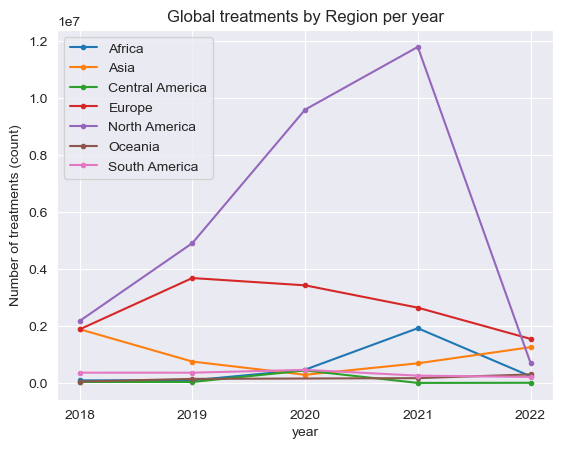

In [37]:
region_data = edited_treatments_df.groupby(["region", "year"], as_index=False)["number_of_treatments"].sum()

for region in region_data['region'].unique():
    region_specific_data = region_data[region_data["region"] == region]
    plt.plot(region_specific_data["year"], region_specific_data["number_of_treatments"], marker='o', linestyle='-', markersize=3, label=region)
plt.ylabel('Number of treatments (count)')
plt.xlabel('year')
plt.xticks(edited_treatments_df['year'].unique())
plt.title('Global treatments by Region per year')
plt.legend()
plt.show()

As we see from the figure above, we see an anomaly in N.America, with differences three times larger than other regions, then a sudden dip in 2022. We would like to see how the different countries' values change, in order to investigate this behaviour.

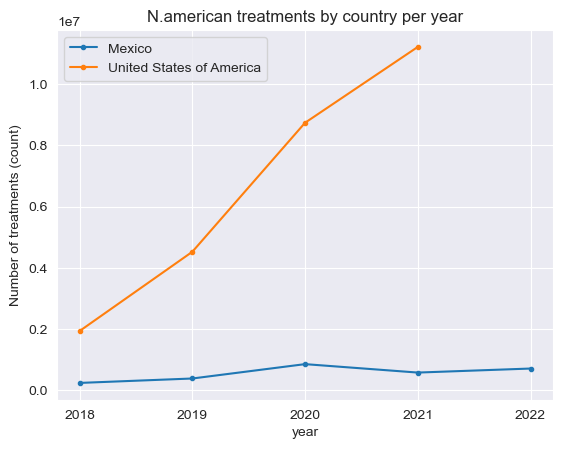

In [38]:
n_america_treatments = edited_treatments_df[edited_treatments_df["region"] == 'North America']
n_america_treatments = n_america_treatments.groupby(["country", "year"], as_index=False)["number_of_treatments"].sum()
n_america_countries = n_america_treatments['country'].unique()

for c in n_america_countries:
    data = n_america_treatments[n_america_treatments["country"] == c]
    plt.plot(data["year"], data["number_of_treatments"], marker='o', linestyle='-', markersize=3, label=c)
plt.ylabel('Number of treatments (count)')
plt.xlabel('year')
plt.xticks(edited_treatments_df['year'].unique())
plt.title('N.american treatments by country per year')
plt.legend()
plt.show()

As we can see, the reason for the low value in N.America came from the missing treatment value of the US. What is more interesting, is that we don't see values from *Canada*, which could be problematic because it's a country that is promoting legalization.

#### analysis of incidents by gender

Firstly, we'd like to check how many countries have reported gender-specific values for each year, to see whether we should factor it in our model's output instead of the total

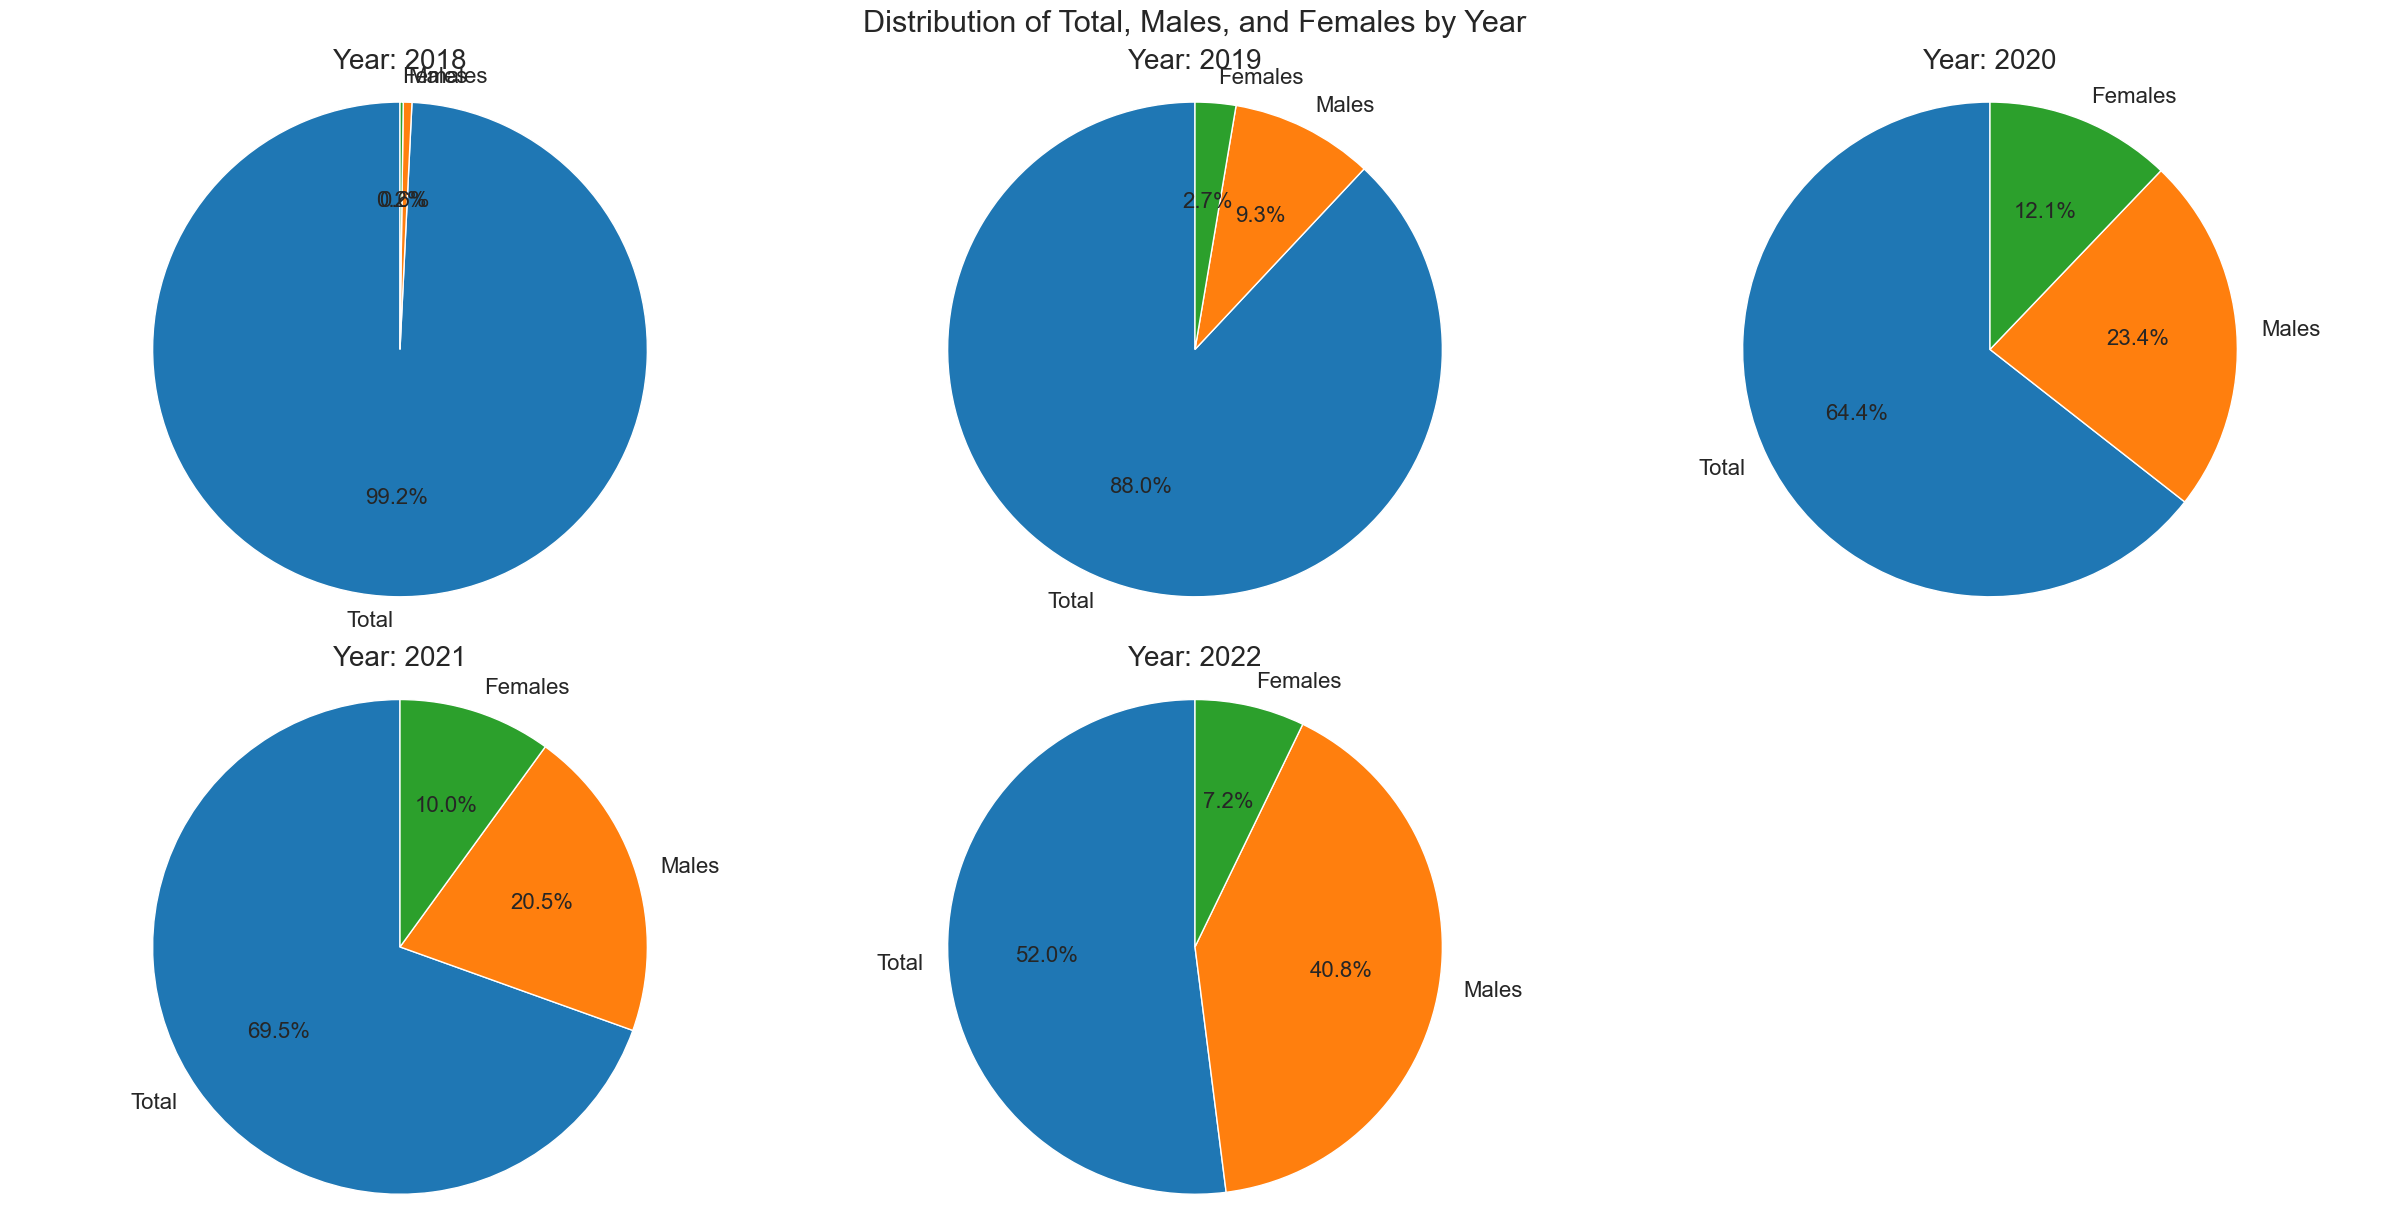

In [39]:
# Pivot the table to get gender as columns and number_of_treatments as values
pivot_df = edited_treatments_df.pivot_table(index='year', columns='gender', values='number_of_treatments', aggfunc='sum')

# If 'Total' is not present as a gender, calculate it as sum of 'Males' and 'Females'
if 'Total' not in pivot_df.columns:
    if 'Males' in pivot_df.columns and 'Females' in pivot_df.columns:
        pivot_df['Total'] = pivot_df['Males'] + pivot_df['Females']
    else:
        # Handle cases where 'Males' or 'Females' might also be missing.
        # This scenario needs to be handled based on user's definition of Total.
        # For now, it is assumed 'Total' will be a sum of 'Males' and 'Females'
        # if 'Total' column is missing or it will already be present in the df
        print("Warning: 'Total', 'Males', or 'Females' not found. Pie charts might not be accurate.")

# Select the columns for plotting, ensuring 'Total' is included for cases where it exists as a gender
# The user specifically asked for 'Total', 'Males', and 'Females', so I will use these columns for the plot.
# I will make sure the columns exist and are ordered for plotting.
columns_to_plot = ['Total', 'Males', 'Females']
available_columns = [col for col in columns_to_plot if col in pivot_df.columns]
data_to_plot = pivot_df[available_columns]

# Plotting the pie charts
num_years = len(data_to_plot)
cols = 3  # Number of columns for subplots
rows = (num_years + cols - 1) // cols  # Calculate number of rows

fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 6))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, (year, data) in enumerate(data_to_plot.iterrows()):
    ax = axes[i]
    labels = data.index.tolist()
    sizes = data.values.tolist()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 16})
    ax.set_title(f'Year: {year}', fontsize=20)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Distribution of Total, Males, and Females by Year', y=1.02, fontsize=22)
plt.show()

As we can see, most early years don't provide gender-specific information, and as such making it hard to rely on it has a possible observed variable.

However, a few insights that we do gain is about the differences between drug consumption between men and women. It can be clearly seen that there are fewer cases of reported treatment cases of women than men. That said, it could be for external reasons - like countries (maybe more religious ones for example) that were reluctant to report such data.

We do see that in this case and the trafficking incidents dataset, this is a male dominant field, so it is somewhat explains the numbers.

Last thing we want to check before we dismiss `gender` as a viable variable to consider in our model is to see its correlation with the total value reported.

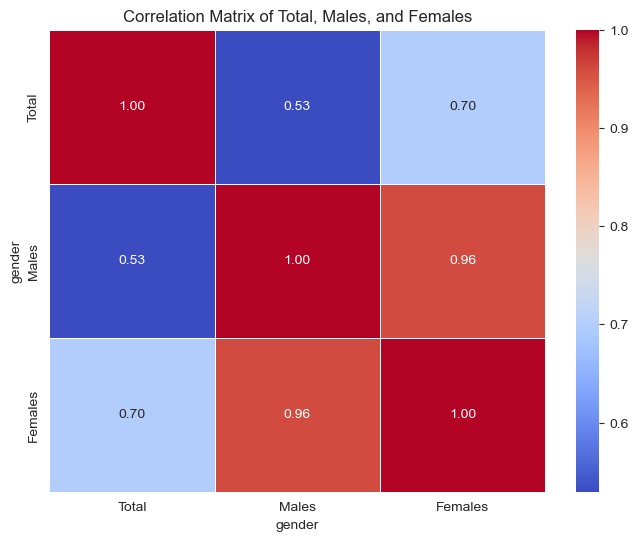

In [40]:
# Select the columns for correlation calculation
columns_for_correlation = [col for col in ['Total', 'Males', 'Females'] if col in pivot_df.columns]
correlation_data = pivot_df[columns_for_correlation]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Total, Males, and Females')
plt.show()

From the correlation matrix we can see immediately that using both female and male is not advisable, since they're heavily correlated. With relation to the *Total* incidents, we see that both genders are correlated, albeit *Males* less so.

We will try to engineer a new variable that expresses the ratio between the two genders, and see if it is more correlated with the total value.


In [41]:
edited_treatments_df = dputil.convert_gender_to_ratio(edited_treatments_df, ['region', 'country', 'year', 'drug_group'], 'number_of_treatments', gender_values=['Females', 'Males'])


#### Lastly, we will analyze the treatments for different drug groups:

In [42]:
print("list of drug types")
pprint(edited_treatments_df['drug_group'].unique().tolist())

list of drug types
['Amphetamine-type stimulants',
 'Any drug',
 'Cannabis-type drugs',
 'Non-specified',
 'Other drugs / psychoactive substances / pharmaceutical products not listed '
 'above',
 'Cocaine-type drugs',
 'Opioids, including opiates and synthetic opioids',
 'Solvents and inhalants',
 'Hallucinogens',
 'Non-medical use of pharmaceutical sedatives and tranquillizers',
 '“Ecstasy”-type substances',
 'New psychoactive substances',
 'Other miscellaneous',
 'Substances not under international control']


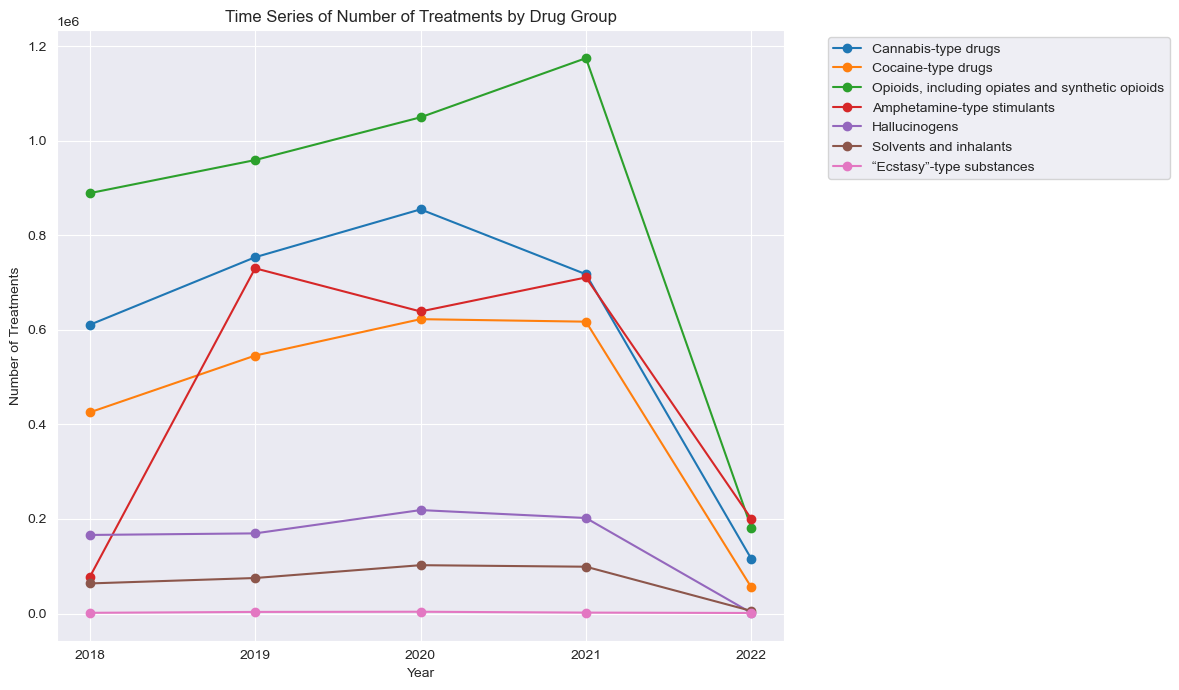

In [43]:
# Define the target drug groups
drug_groups_to_plot = [
    'Cannabis-type drugs',
    'Cocaine-type drugs',
    'Opioids, including opiates and synthetic opioids',
    'Amphetamine-type stimulants',
    'Hallucinogens',
    'Solvents and inhalants',
    '“Ecstasy”-type substances'
]

# Filter the DataFrame for the specified drug groups
filtered_df = edited_treatments_df[edited_treatments_df['drug_group'].isin(drug_groups_to_plot)]

# Aggregate the number_of_treatments by year and drug_group
time_series_data = filtered_df.groupby(['year', 'drug_group'])['total_treatments'].sum().unstack()

# Plotting the time-series
plt.figure(figsize=(12, 7))

for drug_group in drug_groups_to_plot:
    if drug_group in time_series_data.columns:
        plt.plot(time_series_data.index, time_series_data[drug_group], marker='o', label=drug_group)
    else:
        print(f"Warning: Data for '{drug_group}' not found in the filtered dataset.")

plt.xlabel('Year')
plt.xticks(time_series_data.index)
plt.ylabel('Number of Treatments')
plt.title('Time Series of Number of Treatments by Drug Group')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Interestingly, we see the most treatments were given to the *Opioids* and *Amphetamines* drug types, which were less common than *Cocaine* or *Cannabis* in the trafficking and seizure datasets. This then indicates that these types of drugs are **more dangerous** than the other.

Like in the case which the [continental analysis](#4521---analysis-of-yearly-counts-of-treatments-by-continent) had a steep incline in 2022, we suspect that this is due to the *US*'s missing values, being a country that is known to suffer from consumptions of such drugs (see [article.1](https://hsph.harvard.edu/news/what-led-to-the-opioid-crisis-and-how-to-fix-it/) and [article.2](https://www.frontiersin.org/journals/psychiatry/articles/10.3389/fpsyt.2025.1460341/full)).
